<div >
<img src = "../banner.jpg" />
</div>

<a target="_blank" href="https://colab.research.google.com/github/ignaciomsarmiento/BDML_202401/blob/main/Modulo07/Modulo07_PCA_Text_as_Data.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# Deep Learning

### Time Series Prediction

We now show how to fit the models for  time series prediction. First, we call the packages, set up the data, and standardize each of the variables.

In [1]:
require("pacman")

p_load("ISLR2","keras")

Loading required package: pacman



In [2]:
xdata <- data.matrix(
    NYSE[, c("DJ_return", "log_volume","log_volatility")]
  )
istrain <- NYSE[, "train"]
xdata <- scale(xdata)

In [3]:
xdata

DJ_return,log_volume,log_volatility
-0.549777908,0.17506050,-4.356717818
0.905125145,1.51716533,-2.528848663
0.434776822,2.28360065,-2.417837124
-0.431361080,0.93509830,-2.366325388
0.046336436,0.22476000,-2.500763436
-1.304018428,0.60586798,-1.365915115
-0.006293266,-0.01365982,-1.505542796
0.377050100,0.04254846,-1.551386330
-0.411684210,-0.41980156,-1.597475326
0.508742889,-0.55601945,-1.564256769


The  variable `istrain` contains a `TRUE` for each year that  is in the training set, and a `FALSE` for each year
 in the test set.

We first write functions to create lagged versions of the three time series.  We start with a function that takes as input a data
matrix and a lag $L$, and returns a lagged version of the matrix. It
simply inserts $L$ rows of `NA` at the top, and truncates the
bottom.

In [4]:
lagm <- function(x, k = 1) {
  n <- nrow(x)
  pad <- matrix(NA, k, ncol(x))
  rbind(pad, x[1:(n - k), ])
}

We now use this function to create a data frame with all the required
lags, as well as the response variable.

In [5]:
arframe <- data.frame(log_volume = xdata[, "log_volume"],
   L1 = lagm(xdata, 1), L2 = lagm(xdata, 2),
   L3 = lagm(xdata, 3), L4 = lagm(xdata, 4),
   L5 = lagm(xdata, 5)
 )

arframe

log_volume,L1.DJ_return,L1.log_volume,L1.log_volatility,L2.DJ_return,L2.log_volume,L2.log_volatility,L3.DJ_return,L3.log_volume,L3.log_volatility,L4.DJ_return,L4.log_volume,L4.log_volatility,L5.DJ_return,L5.log_volume,L5.log_volatility
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.17506050,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1.51716533,-0.549777908,0.17506050,-4.356717818,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2.28360065,0.905125145,1.51716533,-2.528848663,-0.549777908,0.17506050,-4.356717818,NA,NA,NA,NA,NA,NA,NA,NA,NA
0.93509830,0.434776822,2.28360065,-2.417837124,0.905125145,1.51716533,-2.528848663,-0.549777908,0.17506050,-4.356717818,NA,NA,NA,NA,NA,NA
0.22476000,-0.431361080,0.93509830,-2.366325388,0.434776822,2.28360065,-2.417837124,0.905125145,1.51716533,-2.528848663,-0.549777908,0.17506050,-4.356717818,NA,NA,NA
0.60586798,0.046336436,0.22476000,-2.500763436,-0.431361080,0.93509830,-2.366325388,0.434776822,2.28360065,-2.417837124,0.905125145,1.51716533,-2.528848663,-0.549777908,0.17506050,-4.356717818
-0.01365982,-1.304018428,0.60586798,-1.365915115,0.046336436,0.22476000,-2.500763436,-0.431361080,0.93509830,-2.366325388,0.434776822,2.28360065,-2.417837124,0.905125145,1.51716533,-2.528848663
0.04254846,-0.006293266,-0.01365982,-1.505542796,-1.304018428,0.60586798,-1.365915115,0.046336436,0.22476000,-2.500763436,-0.431361080,0.93509830,-2.366325388,0.434776822,2.28360065,-2.417837124
-0.41980156,0.377050100,0.04254846,-1.551386330,-0.006293266,-0.01365982,-1.505542796,-1.304018428,0.60586798,-1.365915115,0.046336436,0.22476000,-2.500763436,-0.431361080,0.93509830,-2.366325388


If we look at the first five rows of this frame, we will see some
missing values in the lagged variables (due to the construction above). We remove these rows, and adjust `istrain`
accordingly.

In [6]:
arframe <- arframe[-(1:5), ]
istrain <- istrain[-(1:5)]

arframe

,log_volume,L1.DJ_return,L1.log_volume,L1.log_volatility,L2.DJ_return,L2.log_volume,L2.log_volatility,L3.DJ_return,L3.log_volume,L3.log_volatility,L4.DJ_return,L4.log_volume,L4.log_volatility,L5.DJ_return,L5.log_volume,L5.log_volatility
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,0.60586798,0.046336436,0.22476000,-2.500763436,-0.431361080,0.93509830,-2.366325388,0.434776822,2.28360065,-2.417837124,0.905125145,1.51716533,-2.528848663,-0.549777908,0.17506050,-4.356717818
7,-0.01365982,-1.304018428,0.60586798,-1.365915115,0.046336436,0.22476000,-2.500763436,-0.431361080,0.93509830,-2.366325388,0.434776822,2.28360065,-2.417837124,0.905125145,1.51716533,-2.528848663
8,0.04254846,-0.006293266,-0.01365982,-1.505542796,-1.304018428,0.60586798,-1.365915115,0.046336436,0.22476000,-2.500763436,-0.431361080,0.93509830,-2.366325388,0.434776822,2.28360065,-2.417837124
9,-0.41980156,0.377050100,0.04254846,-1.551386330,-0.006293266,-0.01365982,-1.505542796,-1.304018428,0.60586798,-1.365915115,0.046336436,0.22476000,-2.500763436,-0.431361080,0.93509830,-2.366325388
10,-0.55601945,-0.411684210,-0.41980156,-1.597475326,0.377050100,0.04254846,-1.551386330,-0.006293266,-0.01365982,-1.505542796,-1.304018428,0.60586798,-1.365915115,0.046336436,0.22476000,-2.500763436
11,-0.17673016,0.508742889,-0.55601945,-1.564256769,-0.411684210,-0.41980156,-1.597475326,0.377050100,0.04254846,-1.551386330,-0.006293266,-0.01365982,-1.505542796,-1.304018428,0.60586798,-1.365915115
12,-0.14999325,-0.497503813,-0.17673016,-1.565702685,0.508742889,-0.55601945,-1.564256769,-0.411684210,-0.41980156,-1.597475326,0.377050100,0.04254846,-1.551386330,-0.006293266,-0.01365982,-1.505542796
13,0.26516492,-1.007561483,-0.14999325,-1.192986948,-0.497503813,-0.17673016,-1.565702685,0.508742889,-0.55601945,-1.564256769,-0.411684210,-0.41980156,-1.597475326,0.377050100,0.04254846,-1.551386330
14,0.48338656,1.242476790,0.26516492,-0.722591355,-1.007561483,-0.14999325,-1.192986948,-0.497503813,-0.17673016,-1.565702685,0.508742889,-0.55601945,-1.564256769,-0.411684210,-0.41980156,-1.597475326


# AR Model

We now fit the linear AR model to the training data using `lm()`, and predict on the
test data.

In [7]:
arfit <- lm(log_volume ~ ., data = arframe[istrain, ])
arpred <- predict(arfit, arframe[!istrain, ])

mean((arpred - arframe[!istrain, "log_volume"])^2) 

[1] 0.6185263

We refit this model, including the factor variable `day_of_week`.

In [8]:
arframed <- data.frame(day = NYSE[-(1:5), "day_of_week"], arframe)

arframed


,day,log_volume,L1.DJ_return,L1.log_volume,L1.log_volatility,L2.DJ_return,L2.log_volume,L2.log_volatility,L3.DJ_return,L3.log_volume,L3.log_volatility,L4.DJ_return,L4.log_volume,L4.log_volatility,L5.DJ_return,L5.log_volume,L5.log_volatility
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,mon,0.60586798,0.046336436,0.22476000,-2.500763436,-0.431361080,0.93509830,-2.366325388,0.434776822,2.28360065,-2.417837124,0.905125145,1.51716533,-2.528848663,-0.549777908,0.17506050,-4.356717818
7,tues,-0.01365982,-1.304018428,0.60586798,-1.365915115,0.046336436,0.22476000,-2.500763436,-0.431361080,0.93509830,-2.366325388,0.434776822,2.28360065,-2.417837124,0.905125145,1.51716533,-2.528848663
8,wed,0.04254846,-0.006293266,-0.01365982,-1.505542796,-1.304018428,0.60586798,-1.365915115,0.046336436,0.22476000,-2.500763436,-0.431361080,0.93509830,-2.366325388,0.434776822,2.28360065,-2.417837124
9,thur,-0.41980156,0.377050100,0.04254846,-1.551386330,-0.006293266,-0.01365982,-1.505542796,-1.304018428,0.60586798,-1.365915115,0.046336436,0.22476000,-2.500763436,-0.431361080,0.93509830,-2.366325388
10,fri,-0.55601945,-0.411684210,-0.41980156,-1.597475326,0.377050100,0.04254846,-1.551386330,-0.006293266,-0.01365982,-1.505542796,-1.304018428,0.60586798,-1.365915115,0.046336436,0.22476000,-2.500763436
11,mon,-0.17673016,0.508742889,-0.55601945,-1.564256769,-0.411684210,-0.41980156,-1.597475326,0.377050100,0.04254846,-1.551386330,-0.006293266,-0.01365982,-1.505542796,-1.304018428,0.60586798,-1.365915115
12,tues,-0.14999325,-0.497503813,-0.17673016,-1.565702685,0.508742889,-0.55601945,-1.564256769,-0.411684210,-0.41980156,-1.597475326,0.377050100,0.04254846,-1.551386330,-0.006293266,-0.01365982,-1.505542796
13,wed,0.26516492,-1.007561483,-0.14999325,-1.192986948,-0.497503813,-0.17673016,-1.565702685,0.508742889,-0.55601945,-1.564256769,-0.411684210,-0.41980156,-1.597475326,0.377050100,0.04254846,-1.551386330
14,thur,0.48338656,1.242476790,0.26516492,-0.722591355,-1.007561483,-0.14999325,-1.192986948,-0.497503813,-0.17673016,-1.565702685,0.508742889,-0.55601945,-1.564256769,-0.411684210,-0.41980156,-1.597475326


In [9]:
arfitd <- lm(log_volume ~ ., data = arframed[istrain, ])
arpredd <- predict(arfitd, arframed[!istrain, ])

mean((arpredd - arframe[!istrain, "log_volume"])^2) 

[1] 0.5693642

## RNN

To fit the RNN, we need to reshape these data, since it expects a
sequence of $L=5$ feature vectors $X={X_\ell}_1^L$ for each observation, as in (10.20) on
page 428. These are  lagged versions of the
time series going back $L$ time points.

In [10]:
n <- nrow(arframe)
xrnn <- data.matrix(arframe[, -1])
xrnn 


,L1.DJ_return,L1.log_volume,L1.log_volatility,L2.DJ_return,L2.log_volume,L2.log_volatility,L3.DJ_return,L3.log_volume,L3.log_volatility,L4.DJ_return,L4.log_volume,L4.log_volatility,L5.DJ_return,L5.log_volume,L5.log_volatility
6,0.046336436,0.22476000,-2.500763436,-0.431361080,0.93509830,-2.366325388,0.434776822,2.28360065,-2.417837124,0.905125145,1.51716533,-2.528848663,-0.549777908,0.17506050,-4.356717818
7,-1.304018428,0.60586798,-1.365915115,0.046336436,0.22476000,-2.500763436,-0.431361080,0.93509830,-2.366325388,0.434776822,2.28360065,-2.417837124,0.905125145,1.51716533,-2.528848663
8,-0.006293266,-0.01365982,-1.505542796,-1.304018428,0.60586798,-1.365915115,0.046336436,0.22476000,-2.500763436,-0.431361080,0.93509830,-2.366325388,0.434776822,2.28360065,-2.417837124
9,0.377050100,0.04254846,-1.551386330,-0.006293266,-0.01365982,-1.505542796,-1.304018428,0.60586798,-1.365915115,0.046336436,0.22476000,-2.500763436,-0.431361080,0.93509830,-2.366325388
10,-0.411684210,-0.41980156,-1.597475326,0.377050100,0.04254846,-1.551386330,-0.006293266,-0.01365982,-1.505542796,-1.304018428,0.60586798,-1.365915115,0.046336436,0.22476000,-2.500763436
11,0.508742889,-0.55601945,-1.564256769,-0.411684210,-0.41980156,-1.597475326,0.377050100,0.04254846,-1.551386330,-0.006293266,-0.01365982,-1.505542796,-1.304018428,0.60586798,-1.365915115
12,-0.497503813,-0.17673016,-1.565702685,0.508742889,-0.55601945,-1.564256769,-0.411684210,-0.41980156,-1.597475326,0.377050100,0.04254846,-1.551386330,-0.006293266,-0.01365982,-1.505542796
13,-1.007561483,-0.14999325,-1.192986948,-0.497503813,-0.17673016,-1.565702685,0.508742889,-0.55601945,-1.564256769,-0.411684210,-0.41980156,-1.597475326,0.377050100,0.04254846,-1.551386330
14,1.242476790,0.26516492,-0.722591355,-1.007561483,-0.14999325,-1.192986948,-0.497503813,-0.17673016,-1.565702685,0.508742889,-0.55601945,-1.564256769,-0.411684210,-0.41980156,-1.597475326
15,0.262663474,0.48338656,-0.835234760,1.242476790,0.26516492,-0.722591355,-1.007561483,-0.14999325,-1.192986948,-0.497503813,-0.17673016,-1.565702685,0.508742889,-0.55601945,-1.564256769


In [11]:
xrnn <- array(xrnn, c(n, 3, 5))
xrnn <- xrnn[,, 5:1]
xrnn <- aperm(xrnn, c(1, 3, 2))
dim(xrnn)

[1] 6046    5    3

In [12]:
xrnn

, , 1

                 [,1]          [,2]          [,3]          [,4]          [,5]
   [1,] -0.5497779085  0.9051251454  0.4347768223 -0.4313610801  0.0463364355
   [2,]  0.9051251454  0.4347768223 -0.4313610801  0.0463364355 -1.3040184276
   [3,]  0.4347768223 -0.4313610801  0.0463364355 -1.3040184276 -0.0062932660
   [4,] -0.4313610801  0.0463364355 -1.3040184276 -0.0062932660  0.3770501002
   [5,]  0.0463364355 -1.3040184276 -0.0062932660  0.3770501002 -0.4116842098
   [6,] -1.3040184276 -0.0062932660  0.3770501002 -0.4116842098  0.5087428892
   [7,] -0.0062932660  0.3770501002 -0.4116842098  0.5087428892 -0.4975038131
   [8,]  0.3770501002 -0.4116842098  0.5087428892 -0.4975038131 -1.0075614830
   [9,] -0.4116842098  0.5087428892 -0.4975038131 -1.0075614830  1.2424767904
  [10,]  0.5087428892 -0.4975038131 -1.0075614830  1.2424767904  0.2626634742
  [11,] -0.4975038131 -1.0075614830  1.2424767904  0.2626634742 -0.4127510280
  [12,] -1.0075614830  1.2424767904  0.2626634742 -0.4127510280  0.2171458946
  [13,]  1.2424767904  0.2626634742 -0.4127510280  0.2171458946  0.6960287638
  [14,]  0.2626634742 -0.4127510280  0.2171458946  0.6960287638 -0.2176418194
  [15,] -0.4127510280  0.2171458946  0.6960287638 -0.2176418194  0.1373715948
  [16,]  0.2171458946  0.6960287638 -0.2176418194  0.1373715948  0.1008627028
  [17,]  0.6960287638 -0.2176418194  0.1373715948  0.1008627028 -0.9901367845
  [18,] -0.2176418194  0.1373715948  0.1008627028 -0.9901367845  1.9112533123
  [19,]  0.1373715948  0.1008627028 -0.9901367845  1.9112533123  0.8431311502
  [20,]  0.1008627028 -0.9901367845  1.9112533123  0.8431311502 -0.0371124605
  [21,] -0.9901367845  1.9112533123  0.8431311502 -0.0371124605  1.3566263456
  [22,]  1.9112533123  0.8431311502 -0.0371124605  1.3566263456 -0.3540760230
  [23,]  0.8431311502 -0.0371124605  1.3566263456 -0.3540760230  0.2466612001
  [24,] -0.0371124605  1.3566263456 -0.3540760230  0.2466612001  0.3484830775
  [25,]  1.3566263456 -0.3540760230  0.2466612001  0.3484830775  0.7074081588
  [26,] -0.3540760230  0.2466612001  0.3484830775  0.7074081588 -3.2898413753
  [27,]  0.2466612001  0.3484830775  0.7074081588 -3.2898413753  2.0595410523
  [28,]  0.3484830775  0.7074081588 -3.2898413753  2.0595410523  0.6821601263
  [29,]  0.7074081588 -3.2898413753  2.0595410523  0.6821601263 -0.1020698398
  [30,] -3.2898413753  2.0595410523  0.6821601263 -0.1020698398  0.4574170768
  [31,]  2.0595410523  0.6821601263 -0.1020698398  0.4574170768  0.0298600200
  [32,]  0.6821601263 -0.1020698398  0.4574170768  0.0298600200  0.3381705009
  [33,] -0.1020698398  0.4574170768  0.0298600200  0.3381705009 -0.1242359528
  [34,]  0.4574170768  0.0298600200  0.3381705009 -0.1242359528  0.4543351573
  [35,]  0.0298600200  0.3381705009 -0.1242359528  0.4543351573  0.5323314266
  [36,]  0.3381705009 -0.1242359528  0.4543351573  0.5323314266  0.1246883109
  [37,] -0.1242359528  0.4543351573  0.5323314266  0.1246883109 -0.9172375359
  [38,]  0.4543351573  0.5323314266  0.1246883109 -0.9172375359  0.7225806853
  [39,]  0.5323314266  0.1246883109 -0.9172375359  0.7225806853  0.0380389600
  [40,]  0.1246883109 -0.9172375359  0.7225806853  0.0380389600 -0.2259392949
  [41,] -0.9172375359  0.7225806853  0.0380389600 -0.2259392949 -0.1445055000
  [42,]  0.7225806853  0.0380389600 -0.2259392949 -0.1445055000  0.1910681146
  [43,]  0.0380389600 -0.2259392949 -0.1445055000  0.1910681146 -0.6181728133
  [44,] -0.2259392949 -0.1445055000  0.1910681146 -0.6181728133  0.1237400280
  [45,] -0.1445055000  0.1910681146 -0.6181728133  0.1237400280 -0.9275501125
  [46,]  0.1910681146 -0.6181728133  0.1237400280 -0.9275501125  0.3087737307
  [47,] -0.6181728133  0.1237400280 -0.9275501125  0.3087737307  0.8690903948
  [48,]  0.1237400280 -0.9275501125  0.3087737307  0.8690903948  0.5236783450
  [49,] -0.9275501125  0.3087737307  0.8690903948  0.5236783450  0.1882232658
  [50,]  0.3087737307  0.8690903948  0.5236783450  0.1882232658  0.4773310178
  [51,]  0.8690

We have done this in four steps. The first simply extracts the
$n\times 15$ matrix of lagged versions of the three predictor
variables from `arframe`. The second converts this matrix to an
$n\times 3\times 5$ array. We can do this by simply changing the
dimension attribute, since the new array is filled column wise. The
third step reverses the order of lagged variables, so that index $1$
is furthest back in time, and index $5$ closest. The
final step rearranges the coordinates of the array (like a partial
transpose) into the format that the RNN module in `keras`
expects.

Now we are ready to proceed with the RNN, which uses 12 hidden units.

In [13]:
model <- keras_model_sequential() %>%
  layer_simple_rnn(units = 12,
      input_shape = list(5, 3),
      dropout = 0.1, recurrent_dropout = 0.1) %>%
  layer_dense(units = 1)

model %>% compile(optimizer = optimizer_rmsprop(),
    loss = "mse")

We specify two forms of dropout for the units feeding into the  hidden
 layer. The first is for
the input sequence feeding into this layer, and the second is for the
previous hidden units feeding into the layer.
The output layer has a single unit for the response.

We  fit the model in a similar fashion to previous networks. We
supply the `fit` function with test data as validation data, so that when
we monitor its progress and plot the history function we can see the
progress on the test data. Of course we should not use this as a basis for
early stopping, since then the test performance would be biased.

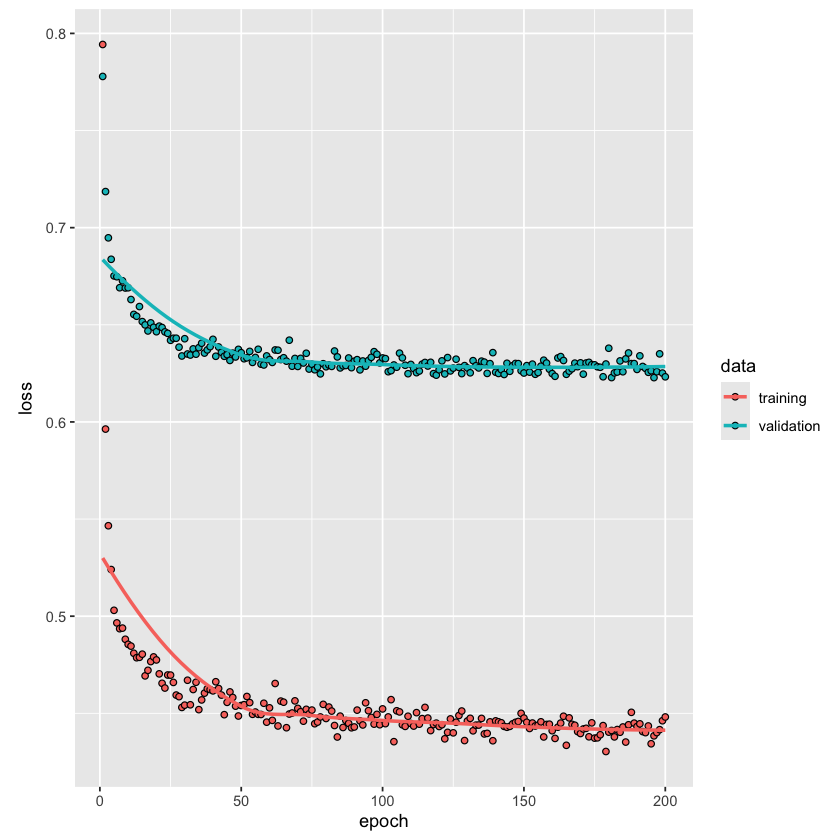

In [14]:
history <- model %>% fit(
    xrnn[istrain,, ], arframe[istrain, "log_volume"],
    batch_size = 64, epochs = 200,
    validation_data =
      list(xrnn[!istrain,, ], arframe[!istrain, "log_volume"])
  )

plot(history)

In [15]:
kpred <- predict(model, xrnn[!istrain,, ])
mean((kpred - arframe[!istrain, "log_volume"])^2)

[1] 0.6232284

 This model takes about one minute to train.

We could replace the  `keras_model_sequential()`  command above with the following command:

In [16]:
model <- keras_model_sequential() %>%
  layer_flatten(input_shape = c(5, 3)) %>%
  layer_dense(units = 1)

Here, `layer_flatten()` simply takes the input sequence and
turns it into a long vector of predictors. This results in a linear AR model.
To fit a nonlinear AR model, we could add in a hidden layer.

However, since we already have the matrix of lagged variables from the AR
model that we fit earlier using the `lm()` command, we can actually fit a nonlinear AR model without needing to perform flattening.
We extract the model matrix `x` from `arframed`, which
includes the `day_of_week` variable.

In [17]:
x <- model.matrix(log_volume ~ . - 1, data = arframed)
colnames(x)

[1] "dayfri"            "daymon"            "daythur"          
 [4] "daytues"           "daywed"            "L1.DJ_return"     
 [7] "L1.log_volume"     "L1.log_volatility" "L2.DJ_return"     
[10] "L2.log_volume"     "L2.log_volatility" "L3.DJ_return"     
[13] "L3.log_volume"     "L3.log_volatility" "L4.DJ_return"     
[16] "L4.log_volume"     "L4.log_volatility" "L5.DJ_return"     
[19] "L5.log_volume"     "L5.log_volatility"

The `-1` in the formula avoids the creation of a column of ones for
the intercept. The variable `day_of_week` is a five-level
factor (there are five trading days), and the
 `-1` results in  five rather than four dummy variables.

The rest of the steps to fit a nonlinear AR model should by now be familiar.

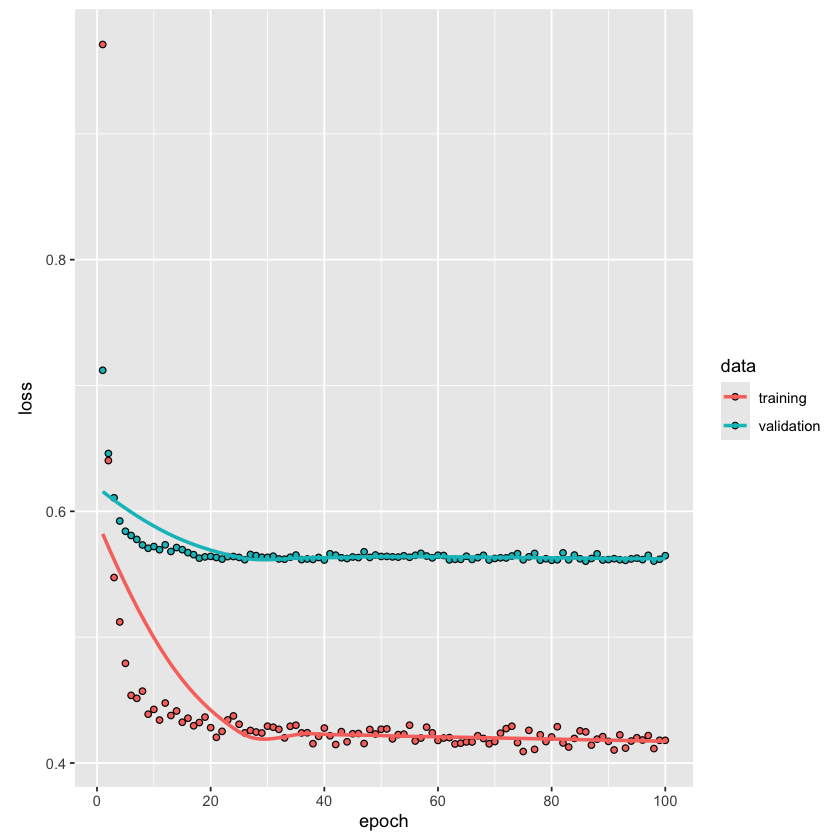

In [18]:
arnnd <- keras_model_sequential() %>%
  layer_dense(units = 32, activation = 'relu',
      input_shape = ncol(x)) %>%
  layer_dropout(rate = 0.5) %>%
  layer_dense(units = 1)
arnnd %>% compile(loss = "mse",
    optimizer = optimizer_rmsprop())
history <- arnnd %>% fit(
    x[istrain, ], arframe[istrain, "log_volume"], epochs = 100, 
    batch_size = 32, validation_data =
      list(x[!istrain, ], arframe[!istrain, "log_volume"])
  )
plot(history)


In [19]:
npred <- predict(arnnd, x[!istrain, ])
mean((arframe[!istrain, "log_volume"] - npred)^2) 

[1] 0.5647643